In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import geopandas as gpd
import mscthesis
import plotly.express as px
import plotly as plt
import plotly.graph_objects as pgo
from plotly.offline import init_notebook_mode
import numpy as np

In [5]:
init_notebook_mode(connected=True)

In [6]:
geotweets = mscthesis.tweets_from_sqlite("Sweden.sqlite3")

In [7]:
geotweets['createdat'] = pd.to_datetime(geotweets['createdat'], infer_datetime_format=True)

In [8]:
geotweets = geotweets.set_index(['userid', 'createdat']).sort_index()

# Filter out users few tweets

We assume that no patterns will emerge for users with less than 50 tweets, due to sparsity.


count    7773.000000
mean      377.817831
std       514.716107
min         1.000000
25%        66.000000
50%       189.000000
75%       474.000000
max      5948.000000
dtype: float64

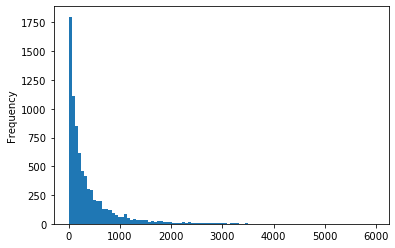

In [9]:
tweet_count_before = geotweets.groupby('userid').size()
tweet_count_before.plot.hist(bins=100)
tweet_count_before.describe()

In [10]:
geotweets = geotweets.drop(
    labels=tweet_count_before[tweet_count_before <= 50].index, 
    level=0,
)

count    6216.000000
mean      466.435489
std       540.409962
min        51.000000
25%       133.000000
50%       275.000000
75%       586.000000
max      5948.000000
dtype: float64

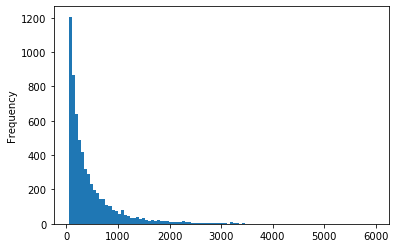

In [11]:
tweet_count = geotweets.groupby('userid').size()
tweet_count.plot.hist(bins=100)
tweet_count.describe()

In [12]:
geotweets = geotweets.reset_index('createdat')

In [13]:
geotweets = geotweets.assign(ym=geotweets['createdat'].dt.to_period('M'))

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1099: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [14]:
_geotweets = geotweets.loc[geotweets.index.unique()[:100]]

# Home location

In [15]:
geotweetsx = mscthesis.cluster(geotweets)
_geotweetsx = mscthesis.cluster(_geotweets)


In [17]:
geotweetsx = mscthesis.label_home(geotweetsx)
_geotweetsx = mscthesis.label_home(_geotweetsx)

## Remove tweets not in home period

Considering the long period of tweets, it is likely that users have moved between homes. To simplify our model we only keep tweets that are during detected home's "period".


In [19]:
geotweetsx = mscthesis.remove_tweets_outside_home_period(geotweetsx)
_geotweetsx = mscthesis.remove_tweets_outside_home_period(_geotweetsx)

In [20]:
user_active_period_before = geotweets.groupby('userid').apply(lambda df: df.createdat.max() - df.createdat.min())
user_active_period_after = geotweetsx.groupby('userid').apply(lambda df: df.createdat.max() - df.createdat.min())
pgo.Figure(
    [
        pgo.Histogram(x=user_active_period_before.dt.days, name="Before"),
        pgo.Histogram(x=user_active_period_after.dt.days, name="After"),
    ],
    pgo.Layout(xaxis=dict(title='Days active')),
)

In [21]:
old = geotweets.groupby('ym').size()
new = geotweetsx.groupby('ym').size()
pgo.Figure([
    pgo.Bar(x=old.index.astype(str), y=old.values, name="Before"),
    pgo.Bar(x=new.index.astype(str), y=new.values, name="After")
])

## Remove users not in Sweden

In [22]:
def get_homelocations(ts):
    _ts = ts.query('label == "home"').groupby(['userid', 'region']).head(1)
    return gpd.GeoDataFrame(
        _ts,
        crs='EPSG:4326',
        geometry=gpd.points_from_xy(_ts['longitude'], _ts['latitude'])
    )
        
homelocations = get_homelocations(geotweetsx)
_homelocations = get_homelocations(_geotweetsx)

In [23]:
fig = px.scatter_mapbox(
    homelocations.reset_index(), 
    lat='latitude', lon='longitude', 
    hover_data = ['userid']
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

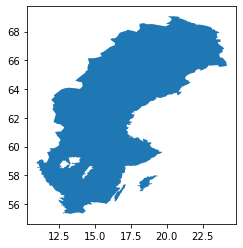

In [24]:
sweden = gpd.read_file('../../dbs/alla_lan/alla_lan.shp') \
    .assign(a=1).dissolve(by='a') \
    .simplify(tolerance=0.2) \
    .to_crs('EPSG:4326')
sweden.plot()

In [25]:
homelocationsx = gpd.clip(homelocations, sweden)
_homelocationsx = gpd.clip(_homelocations, sweden)

In [26]:
homelocationsx

,region,createdat,tweetid,latitude,longitude,month,weekday,hourofday,timezone,ym,label,geometry
userid,,,,,,,,,,,,
5616,5,2013-03-09 17:45:46+00:00,310446326309584896,59.426889,17.954336,3,6,18,Europe/Stockholm,2013-03,home,POINT (17.95434 59.42689)
5976,11,2015-05-24 08:04:30+00:00,602384663596830720,56.053940,12.684570,5,0,10,Europe/Stockholm,2015-05,home,POINT (12.68457 56.05394)
8981,8,2013-09-01 08:29:37+00:00,374086629918769152,59.317410,18.026856,9,0,10,Europe/Stockholm,2013-09,home,POINT (18.02686 59.31741)
32213,6,2016-06-23 15:44:26+00:00,746006007185170432,58.050000,11.833333,6,4,17,Europe/Stockholm,2016-06,home,POINT (11.83333 58.05000)
392123,22,2013-07-01 14:21:12+00:00,351707061656092673,59.294972,17.933748,7,1,16,Europe/Stockholm,2013-07,home,POINT (17.93375 59.29497)
...,...,...,...,...,...,...,...,...,...,...,...,...
764655612525473792,3,2016-08-29 16:38:12+00:00,770299525185626113,56.205971,12.592350,8,1,18,Europe/Stockholm,2016-08,home,POINT (12.59235 56.20597)
778179816889675777,2,2016-11-20 15:15:38+00:00,800356936998854657,65.650835,21.966168,11,0,16,Europe/Stockholm,2016-11,home,POINT (21.96617 65.65083)
782260642770288640,3,2016-10-23 15:34:04+00:00,790214714336931841,59.880230,17.656580,10,0,17,Europe/Stockholm,2016-10,home,POINT (17.65658 59.88023)


In [27]:
pgo.Figure(
    [
        pgo.Scattermapbox(lat=homelocations['latitude'], lon=homelocations['longitude'], fillcolor='red'),
        pgo.Scattermapbox(lat=homelocationsx['latitude'], lon=homelocationsx['longitude'], fillcolor='blue'),
    ],
    layout=pgo.Layout(
        
        mapbox=pgo.layout.Mapbox(style='open-street-map'))
)

In [28]:
geotweetsy = geotweetsx[geotweetsx.index.isin(homelocationsx.index)]
_geotweetsy = _geotweetsx[_geotweetsx.index.isin(_homelocationsx.index)]

In [29]:
geotweetsy

,region,createdat,tweetid,latitude,longitude,month,weekday,hourofday,timezone,ym,label
userid,,,,,,,,,,,
5616,0,2015-05-07 15:12:52+00:00,596331871241379840,57.599221,18.436371,5,4,17,Europe/Stockholm,2015-05,other
5616,0,2015-07-20 09:12:12+00:00,623057810864111616,57.599221,18.436371,7,1,11,Europe/Stockholm,2015-07,other
5616,0,2015-12-23 14:43:00+00:00,679673567416565760,57.599221,18.436371,12,3,15,Europe/Stockholm,2015-12,other
5616,0,2016-07-25 18:42:00+00:00,757647103011262465,57.599221,18.436371,7,1,20,Europe/Stockholm,2016-07,other
5616,0,2016-08-10 06:31:05+00:00,763261365930909696,57.599221,18.436371,8,3,8,Europe/Stockholm,2016-08,other
...,...,...,...,...,...,...,...,...,...,...,...
794973407964229636,116,2019-02-27 13:16:43+00:00,1100746552581201921,59.309151,18.051889,2,3,14,Europe/Stockholm,2019-02,other
794973407964229636,117,2019-03-10 15:10:01+00:00,1104761332384055296,59.292857,18.079165,3,0,16,Europe/Stockholm,2019-03,other
794973407964229636,118,2019-03-12 15:56:22+00:00,1105497771421941760,59.303260,18.098290,3,2,16,Europe/Stockholm,2019-03,other


In [30]:
geotweetsy.to_csv('./geotweets.csv')

In [38]:
homelocationsy = homelocationsx.to_crs('EPSG:3006').reset_index()
homelocationsy = pd.DataFrame.from_dict(dict(
    userid = homelocationsy['userid'],
    x = homelocationsy['geometry'].x,
    y = homelocationsy['geometry'].y,
)).set_index('userid')

In [40]:
homelocationsy.to_csv('./homelocations.csv')